In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from imdb import Cinemagoer
import pycountry

### Import datasets

In [517]:
file = pd.read_csv("movies_metadata.csv", low_memory = False)
attrs = ["id","title","imdb_id","genres","budget","revenue","production_companies","popularity","spoken_languages","release_date","vote_average","vote_count"]
df = file[attrs]
df = df.dropna()
df = df.reset_index(drop=True)

In [518]:
for i in range(len(df.release_date)):
    df.loc[i,"release_date"] = df.release_date[i][:4]
df = df.sample(frac = 0.05)
#df["release_date"].value_counts()
df["popularity"] = df["popularity"].astype(float)
df = df.sort_values(by = "popularity", ascending = False)
df = df.loc[df.popularity > 1]

# Reference: 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

### Create a genres dictionary: {genres_id : name}

In [519]:
genres = df.genres
genres_dict = {}
new_genres = []
for i in genres:
    i = i.replace("'",'"')
    tmp = json.loads(i)
    res = []
    for j in tmp:
        if j["id"] not in genres_dict:
            genres_dict[j["id"]] = j["name"]
        res.append(genres_dict[j["id"]])
    new_genres.append(res)

In [520]:
print(genres_dict)

{10751: 'Family', 14: 'Fantasy', 10749: 'Romance', 28: 'Action', 12: 'Adventure', 35: 'Comedy', 878: 'Science Fiction', 53: 'Thriller', 80: 'Crime', 18: 'Drama', 16: 'Animation', 36: 'History', 10752: 'War', 9648: 'Mystery', 27: 'Horror', 10402: 'Music', 37: 'Western', 10770: 'TV Movie', 99: 'Documentary', 10769: 'Foreign'}


### Create a production_company dictionary: {company_id : name}

In [521]:
company = df.production_companies
company_dict = {}
new_company = []

for i in company:
    i = i.replace("'",'"')
    try:
        tmp = json.loads(i)
        res = []
        for j in tmp:
            if j["id"] not in company_dict:
                company_dict[j["id"]] = j["name"]
            res.append(company_dict[j["id"]])
        new_company.append(res)
    except:
        new_company.append([])
# Reference: 
# https://www.w3schools.com/python/python_try_except.asp

In [522]:
print(company_dict)

{2: 'Walt Disney Pictures', 10227: 'Mandeville Films', 420: 'Marvel Studios', 14: 'Miramax Films', 59: 'A Band Apart', 216: 'Jersey Films', 429: 'DC Comics', 923: 'Legendary Pictures', 6194: 'Warner Bros.', 9993: 'DC Entertainment', 9996: 'Syncopy', 16076: 'Newgrange Pictures', 78093: 'Paradox Film 3', 12: 'New Line Cinema', 5219: 'Sunswept Entertainment', 8411: 'Metro-Goldwyn-Mayer (MGM)', 79: 'Village Roadshow Pictures', 372: 'Groucho II Film Partnership', 1885: 'Silver Pictures', 7392: 'Twentieth Century Fox', 4: 'Paramount Pictures', 306: 'Twentieth Century Fox Film Corporation', 574: 'Lightstorm Entertainment', 3: 'Pixar Animation Studios', 737: 'Sidney Kimmel Entertainment', 10138: 'Double Nickel Entertainment', 4564: 'Icon Entertainment International', 7965: 'The Ladd Company', 11353: 'B.H. Finance C.V.', 436: '1492 Pictures', 2575: '21 Laps Entertainment', 20478: 'Moving Picture Company (MPC)', 22213: 'TSG Entertainment', 1632: 'Lionsgate', 3528: 'Thunder Road Pictures', 33681:

### Create language dictionary

In [523]:
def lang(s):
    cty = pycountry.languages.get(alpha_2 = s)
    language = cty.name
    return language

In [524]:
language = df.spoken_languages
language_dict = {}
new_language = []
idx = 0
for i in language:
    i = i.replace("'",'"')
    try:
        tmp = json.loads(i)
    except:
        tmp = json.loads('[]')
    
    res = []
    try:
        for j in tmp:
            abbr = j["iso_639_1"]
            if abbr not in language_dict:
                language_dict[abbr] = lang(abbr)
            res.append(language_dict[abbr])
        new_language.append(res)
    except:
        new_language.append([])
# Reference: 
# https://github.com/flyingcircusio/pycountry

In [525]:
print(language_dict)

{'en': 'English', 'es': 'Spanish', 'fr': 'French', 'zh': 'Chinese', 'de': 'German', 'no': 'Norwegian', 'sv': 'Swedish', 'it': 'Italian', 'ru': 'Russian', 'la': 'Latin', 'gd': 'Scottish Gaelic', 'ar': 'Arabic', 'ga': 'Irish', 'ja': 'Japanese', 'pt': 'Portuguese', 'el': 'Modern Greek (1453-)', 'ko': 'Korean', 'da': 'Danish', 'tr': 'Turkish', 'hu': 'Hungarian', 'km': 'Central Khmer', 'mi': 'Maori', 'cs': 'Czech', 'bo': 'Tibetan', 'th': 'Thai', 'hi': 'Hindi', 'cy': 'Welsh', 'pl': 'Polish', 'nl': 'Dutch', 'sr': 'Serbian', 'nv': 'Navajo', 'uk': 'Ukrainian', 'is': 'Icelandic', 'tl': 'Tagalog', 'fi': 'Finnish', 'hy': 'Armenian', 'mn': 'Mongolian', 'vi': 'Vietnamese', 'bs': 'Bosnian', 'af': 'Afrikaans', 'mr': 'Marathi', 'iu': 'Inuktitut', 'lo': 'Lao', 'yi': 'Yiddish', 'gu': 'Gujarati', 'he': 'Hebrew', 'kk': 'Kazakh', 'ca': 'Catalan', 'cr': 'Cree', 'ml': 'Malayalam', 'ka': 'Georgian', 'ro': 'Romanian', 'qu': 'Quechua', 'bn': 'Bengali', 'tg': 'Tajik', 'ta': 'Tamil', 'zu': 'Zulu', 'et': 'Estonian'

### vote_scores computed: IMDb rating system work

#### Weighted Rating (wr) = [v/(v+min)] * R + [min/(v+min)] * C
v: the number of votes for the movie

min: the minimum votes required as threshold

R: the average rating of the movie

C: the mean vote for the dataset

In [526]:
# compute the mean vote: C
v_avg = df["vote_average"].mean()
v_cnt = df["vote_count"].quantile(0.6)
v_df = df.loc[df["vote_count"]>= v_cnt]

# We will use 60th percentile as our cutoff. 
# Each movie selected must have more votes surpass 60% in teh dataset.
# Bases on the size of dataset, more data, higher percentile.

# Reference:
# https://www.quora.com/How-does-IMDbs-rating-system-work

In [527]:
def weighted(movie,v_cnt,v_avg):
    v = movie["vote_count"]
    R = movie["vote_average"]
    return (v/(v+v_cnt) * R) + (v_cnt/(v_cnt+v) * v_avg)

score_lst = []
for i,j in v_df.iterrows():
    movie = j
    score = weighted(movie,v_cnt,v_avg)
    score = round(score,3)
    score_lst.append(score)
v_df["score"] = score_lst

# Reference:
# https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/

/var/folders/t4/ws_p7m097s7_p1t_gg1m0h080000gn/T/ipykernel_99747/3495840658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df["score"] = score_lst


In [528]:
sort_v_df = v_df.sort_values("score", ascending = False)
sort_v_df[["title", "vote_count", "vote_average", "score","popularity"]].head(5)

,title,vote_count,vote_average,score,popularity
12475,The Dark Knight,12269.0,8.3,8.292,123.167259
292,Pulp Fiction,8670.0,8.3,8.289,140.950236
1130,Cinema Paradiso,834.0,8.2,8.097,14.177005
32096,Room,2838.0,8.1,8.070,12.443291
39315,Piper,487.0,8.2,8.030,11.243161


In [529]:
#print(len(sort_v_df))

### Rating Based Recommend System

Text(0.5, 1.0, 'High Rated Movies')

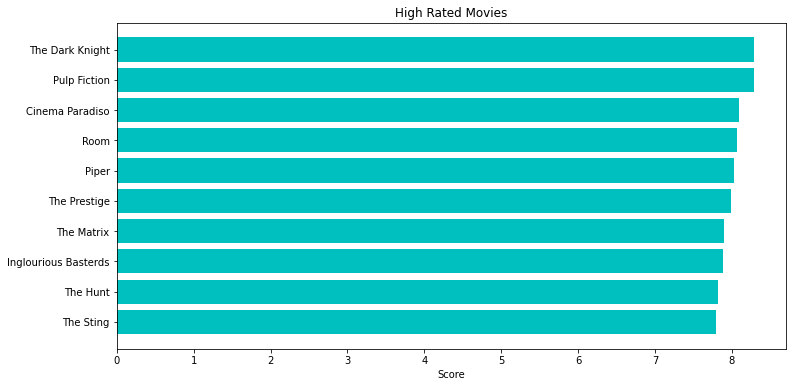

In [531]:
plt.figure(figsize = (12,6))
plt.barh(sort_v_df["title"].head(10),sort_v_df["score"].head(10), align = "center", color = "c")
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("High Rated Movies")

### Popularity Based Recommend System

Text(0.5, 1.0, 'Most Popular Movies')

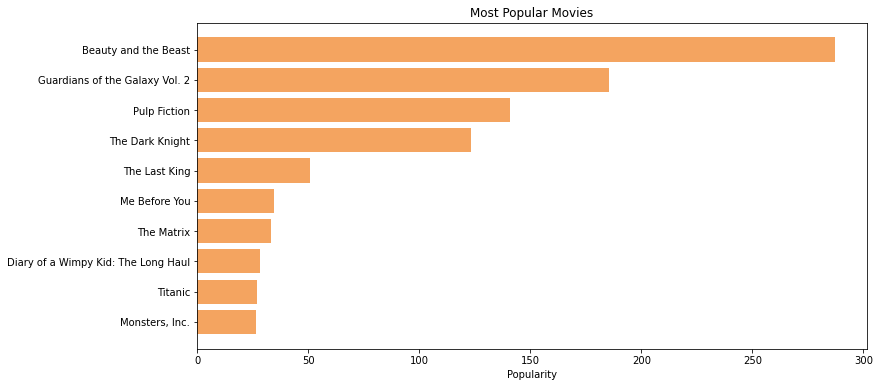

In [532]:
plt.figure(figsize = (12,6))
plt.barh(v_df["title"].head(10),v_df["popularity"].head(10), align = "center", color = "sandybrown")
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Most Popular Movies")

### Cinemagoer: add one more parameter for score recommend system

In [535]:
ia = Cinemagoer()


In [534]:
ia = Cinemagoer()
rows = []

def update(s):
    movie = ia.get_movie(s)
    return movie["rating"]

for i,j in v_df.iterrows():
    base = "https://www.imdb.com/title/"
    link_id = j["imdb_id"] #tt0078748
    link = base + link_id + "/"
    
    search_id = link_id.lstrip("t") #0078748
    try:
        score_online = update(search_id)
        row = [score_online,link]
        rows.append(row)
    #print(row)
    except:
        rows.append([])

2022-11-27 01:56:48,015 CRITICAL [imdbpy] /Users/xiangyuanchi/.local/lib/python3.9/site-packages/imdb/_exceptions.py:32: IMDbDataAccessError exception raised; args: ({'errcode': 54, 'errmsg': 'Connection reset by peer', 'url': 'https://www.imdb.com/title/tt0418279/reference', 'proxy': '', 'exception type': 'IOError', 'original exception': ConnectionResetError(54, 'Connection reset by peer')},); kwds: {}
Traceback (most recent call last):
  File "/Users/xiangyuanchi/.local/lib/python3.9/site-packages/imdb/parser/http/__init__.py", line 222, in retrieve_unicode
    content = response.read()
  File "/Users/xiangyuanchi/opt/anaconda3/lib/python3.9/http/client.py", line 470, in read
    return self._readall_chunked()
  File "/Users/xiangyuanchi/opt/anaconda3/lib/python3.9/http/client.py", line 577, in _readall_chunked
    chunk_left = self._get_chunk_left()
  File "/Users/xiangyuanchi/opt/anaconda3/lib/python3.9/http/client.py", line 560, in _get_chunk_left
    chunk_left = self._read_next_

In [536]:
cinema = pd.DataFrame(rows, columns=["online_score", "imdb_link"])
new_v_df = v_df.reset_index(drop=True)
result = pd.concat([new_v_df, cinema], axis=1, join='inner')
#result = result[]
# Reference: 
# https://www.geeksforgeeks.org/how-to-combine-two-dataframe-in-python-pandas/
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [537]:
result

,id,title,imdb_id,genres,budget,revenue,production_companies,popularity,spoken_languages,release_date,vote_average,vote_count,score,online_score,imdb_link
0,321612,Beauty and the Beast,tt2771200,"[{'id': 10751, 'name': 'Family'}, {'id': 14, '...",160000000,1.262886e+09,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",287.253654,"[{'iso_639_1': 'en', 'name': 'English'}]",2017,6.8,5530.0,6.795,7.1,https://www.imdb.com/title/tt2771200/
1,283995,Guardians of the Galaxy Vol. 2,tt3896198,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",200000000,8.634161e+08,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",185.330992,"[{'iso_639_1': 'en', 'name': 'English'}]",2017,7.6,4858.0,7.587,7.6,https://www.imdb.com/title/tt3896198/
2,680,Pulp Fiction,tt0110912,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",8000000,2.139288e+08,"[{'name': 'Miramax Films', 'id': 14}, {'name':...",140.950236,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",1994,8.3,8670.0,8.289,8.9,https://www.imdb.com/title/tt0110912/
3,155,The Dark Knight,tt0468569,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",185000000,1.004558e+09,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...",123.167259,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2008,8.3,12269.0,8.292,9.0,https://www.imdb.com/title/tt0468569/
4,360249,The Last King,tt4738360,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",5455000,0.000000e+00,"[{'name': 'Newgrange Pictures', 'id': 16076}, ...",50.949523,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",2016,5.2,47.0,5.683,6.1,https://www.imdb.com/title/tt4738360/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,10085,Unrest,tt0453533,"[{'id': 27, 'name': 'Horror'}]",0,0.000000e+00,"[{'name': 'Asgaard Entertainment', 'id': 2714}...",2.159288,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2006,5.3,45.0,5.744,5.0,https://www.imdb.com/title/tt0453533/
481,6007,Elling,tt0279064,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0,0.000000e+00,"[{'name': 'Maipo Film- og TV Produksjon', 'id'...",2.148946,"[{'iso_639_1': 'no', 'name': 'Norsk'}]",2001,7.0,51.0,6.619,7.5,https://www.imdb.com/title/tt0279064/
482,48714,The Big Shave,tt0061402,"[{'id': 18, 'name': 'Drama'}]",0,0.000000e+00,[],2.116885,"[{'iso_639_1': 'en', 'name': 'English'}]",1968,6.9,47.0,6.552,7.0,https://www.imdb.com/title/tt0061402/
483,14016,Mad Detective,tt0969269,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",0,0.000000e+00,"[{'name': 'Milky Way Image Company', 'id': 5632}]",2.061375,"[{'iso_639_1': 'zh', 'name': '普通话'}]",2007,7.0,45.0,6.594,7.1,https://www.imdb.com/title/tt0969269/


# Upload datasets into the firebase & Create an EDFS 

NameNode: Information dataset, which stores the metadata

DataNode:  year(DN_1), genres(DN_2), popularity(DN_3), scores(DN_4), languages(DN_5)

### NameNode Upload: Information dataset

In [538]:
str_genres = []
for i in new_genres:
    item = ", ".join(i)
    str_genres.append(item)

str_company = []
for j in new_company:
    item = ", ".join(j)
    str_company.append(item)

str_language = []
for k in new_language:
    item = ", ".join(k)
    str_language.append(item)
    

In [539]:
information = {"id":df.id,"new_genres": str_genres, "new_company":str_company,"new_language": str_language}
information_df = pd.DataFrame(information)
#print(information_df)
upload_info = pd.merge(df,information_df, how ="left", on = "id")
upload_info = upload_info[["id","title","imdb_id","new_genres","new_company","new_language","release_date","popularity"]]

sub_v_df = v_df[["id", "score"]]
upload_info = pd.merge(upload_info,sub_v_df,how = "left", on = "id")
upload_info = upload_info.dropna()

# Reference: 
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html

In [540]:
cls = list(upload_info.columns)
# ['id', 'title', 'imdb_id', 'new_genres', 'new_company', 'new_language', 'release_date', 'popularity', 'score']

for i,j in upload_info.iterrows():
    data = {}
    for k in range(len(cls)):
        data[cls[k]] = j[k]
    json_data = json.dumps(data, indent = 4)
    url = "https://imdb-movies-d490a-default-rtdb.firebaseio.com/information" + "/" + str(j[1]) + ".json"
    r = requests.put(url,str(json_data))

### DataNode Upload: year, genres, popularity, scores, language

In [541]:
r = requests.get("https://imdb-movies-d490a-default-rtdb.firebaseio.com/information.json")
info_name = r.json()

In [542]:
#info_name

#### DN_1: year

In [551]:
year_dic = {}
for name in info_name:
    item_dic = info_name[name]
    try:
        title = item_dic["title"]
        str_year = item_dic["release_date"]
        if str_year not in year_dic:
            year_dic[str_year] = [title]
        else:
            year_dic[str_year].append(title)
    except:
        continue
        
year_dic = {k:v for k,v in sorted(year_dic.items(), key = lambda x:x[0])}

#### DN_2: genres

In [544]:
genres_new = {}
for name in info_name:
    item_dic = info_name[name]
    try:
        title = item_dic["title"]
        genres_lst = item_dic["new_genres"].split(", ")
        for i in genres_lst:
            if i not in genres_new:
                genres_new[i] = [title]
            else:
                genres_new[i].append(title)
    except:
        continue

#### DN_3: popularity

In [545]:
nums = []
pop_lst = []
for name in info_name:
    item_dic = info_name[name]
    try:
        nums.append(round(item_dic["popularity"]))
        pop_lst.append((name,round(item_dic["popularity"])))
    except:
        continue

In [546]:
sort_nums = list(set(sorted(nums)))
pop_dic = {item:[] for item in sort_nums}
for pop in pop_lst:
    pop_dic[pop[1]].append(pop[0])
pop_dic = {k:v for k,v in sorted(pop_dic.items(), key = lambda x:x[0])}

#### DN_4: score

In [491]:
nums2 = []
score_lst = []
for name in info_name:
    item_dic = info_name[name]
    try:
        nums2.append(round(item_dic["score"]))
        score_lst.append((name,round(item_dic["score"])))
    except:
        continue

In [492]:
sort_nums2 = list(set(sorted(nums2)))
score_dic = {item:[] for item in sort_nums2}
for score in score_lst:
    score_dic[score[1]].append(score[0])
score_dic = {k:v for k,v in sorted(score_dic.items(), key = lambda x:x[0])}

#### DN_5: languages

In [547]:
language_new = {}
for name in info_name:
    item_dic = info_name[name]
    try:
        title = item_dic["title"]
        language_lst = item_dic["new_language"].split(", ")
        for i in language_lst:
            if i not in language_new:
                language_new[i] = [title]
            else:
                language_new[i].append(title)
    except:
        continue

In [548]:
def put_lang(lang):
    base = "https://imdb-movies-d490a-default-rtdb.firebaseio.com/language/"
    link = base + lang + ".json" 
    r = requests.put(link, data = json_object)

for i in language_new:
    if len(i) != 0:
        json_object = json.dumps(language_new[i],indent = 4) # language_new[i] is a list
        genres_db = put_lang(i)
    else:
        continue

#### Upload 4 DataNodes to firebase database

In [553]:
def put(table):
    base = "https://imdb-movies-d490a-default-rtdb.firebaseio.com/"
    link = base + table + "/.json" 
    r = requests.put(link, data = json_object)
    

namelist = ["year","genres","popularity","language"]
dic_lst = [year_dic,genres_new,pop_dic,language_new]

for i in range(len(namelist)):
    for j in dic_lst[i]:
        try:
            if len(j) != 0:
                json_object = json.dumps(dic_lst[i], indent = 4)
                db = put(namelist[i])
            else:
                continue
        except:
            json_object = json.dumps(dic_lst[i], indent = 4)
            db = put(namelist[i])

#### Upload score dataset for further analysis (not for partition)

In [550]:
### score dataset
upload_score = result[["title", "imdb_id","vote_average", "score","online_score"]]
columns = list(upload_score.columns)
for i,j in upload_score.iterrows():
    data = {}
    for k in range(len(columns)):
        data[columns[k]] = j[k]
    json_data = json.dumps(data,indent = 4)
    url = "https://imdb-movies-d490a-default-rtdb.firebaseio.com/scores" + "/" + str(j[0]) + ".json"
    r = requests.put(url, str(json_data))

# We create a Firebase realtime database for upload the scores of each unique movie
# The reference url: https://imdb-movies-d490a-default-rtdb.firebaseio.com/
# People can search the movie based on the score_range (eg: 8-10 by curl command)